In [2]:
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

In [20]:
trial_num = 4

def data_extractor(filename, processed_filename1, processed_filename2=None):
    # cleans IMU outputs and generates usable dataset as a clean CSV file
    
    file = open(filename, 'r')
    out_file1 = open(processed_filename1, 'w')
    if processed_filename2 is not None:
        out_file2 = open(processed_filename2, 'w')
    
    start_time, end_time, time  = '', '', ''
    lin_ctr = 0
    
    for l in file:
        if l[0] == '[':                              # if data has timestamp logging on
            time, line = l[10:22], l[24:].rstrip()
        else:
            line = l.rstrip()
            
        tab_ctr = line.count("\t")
        if tab_ctr == 3 or tab_ctr == 9:
            lin_ctr += 1
            line_lst = line.rstrip().split("\t")
            if line_lst[0]=='LSM_raw: ' :
#                 print(line.rstrip(), file=out_file2, end=";\t\t")
                print(line.rstrip(), file=out_file2, end=";\t")
            elif line_lst[0]=='MPU_raw: ' :
#                 print(line.rstrip(), file=out_file1, end=";\t\t")
                print(line.rstrip(), file=out_file1, end=";\t")
            elif line_lst[0]=='MPU_ypr: ' :
                print(line.rstrip(), file=out_file1, end="\n")
                print(line.rstrip(), file=out_file2, end="\n")
            if lin_ctr == 1 :
                start_time = time
            #elif line_lst[0]=='LSM_ypr: ' :
            #    print(line.rstrip(), file=out_file1, end="\n")
    
    end_time = time
    print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file1, end="\n")
    
    if processed_filename2 is not None:
        print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file2, end="\n")
        out_file2.close()
        
    out_file1.close()
    file.close()

In [21]:
# Data Pre-processing 
# data_extractor("Datasets/MPU_rawtoypr_data.csv", "Datasets/MPU_rawtoypr_data_cleaned.csv")
# data_extractor("Datasets/MPU_rawtoypr_2.csv", "Datasets/MPU_rawtoypr_2_cleaned.csv")
# data_extractor("Datasets/MPU_rawtoypr_3.csv", "Datasets/MPU_rawtoypr_3_cleaned.csv")
# data_extractor("Datasets/MPU_rawtoypr_4.csv", "Datasets/MPU_rawtoypr_4_cleaned.csv")
# data_extractor("Datasets/MPU_rawtoypr_5.csv", "Datasets/MPU_rawtoypr_5_cleaned.csv")
# data_extractor("Datasets/MPU_rawtoypr_6.csv", "Datasets/MPU_rawtoypr_6_cleaned.csv")
# data_extractor("Datasets/MPU_rawtoypr_7.csv", "Datasets/MPU_rawtoypr_7_cleaned.csv")
# data_extractor("Datasets/MPU_rawtoypr_8.csv", "Datasets/MPU_rawtoypr_8_cleaned.csv")
# data_extractor("Datasets/MPU_rawtoypr_9.csv", "Datasets/MPU_rawtoypr_9_cleaned.csv")
# data_extractor("Datasets/MPU_rawtoypr_10.csv", "Datasets/MPU_rawtoypr_10_cleaned.csv")
# data_extractor("Datasets/MPU_rawtoypr_11.csv", "Datasets/MPU_rawtoypr_11_cleaned.csv")


# *** 
# data_extractor("Datasets/rawtoypr_{}.csv".format(trial_num), 
#                "Datasets/MPU_rawtoypr_{}_cleaned.csv".format(trial_num), 
#                "Datasets/LSM_rawto_MPUypr_{}_cleaned.csv".format(trial_num))


#data_extractor("Datasets/trial_dataset1.txt", "Datasets/trial_dataset1_mpu.txt", "Datasets/trial_dataset1_lsm.txt")

data_extractor("Datasets/New_train_test_datasets/drift_test1.txt", "Datasets/New_train_test_datasets/drift_test1_mpu.txt", "Datasets/New_train_test_datasets/drift_test1_lsm.txt")

# data_extractor("Datasets/360_yaw_lpf_42_data.txt", "Datasets/360_yaw_lpf_42_data_cleaned.txt", "Datasets/mpu_360_yaw_lpf_42_data_cleaned.txt")
# data_extractor("Datasets/360_yaw_lpf_98_data.txt", "Datasets/360_yaw_lpf_98_data_cleaned.txt", "Datasets/mpu_360_yaw_lpf_98_data_cleaned.txt")

# data_extractor("Datasets/360_pitch_data.txt", "Datasets/360_pitch_data_cleaned.txt", "Datasets/mpu_360_pitch_data_cleaned.txt")
#data_extractor("Datasets/360_roll_data.txt", "Datasets/360_roll_data_cleaned.txt", "Datasets/mpu_360_roll_data_cleaned.txt")

In [22]:
class Data_loader():
    # Loads data into the model

    def __init__(self, abs_filename, trans=False, sequential_test_mode=True):
        data, self.runtime = self.get_data(abs_filename)
        if self.runtime == 0:
            self.runtime = None
        try:
            self.data_matrix = data.reshape((data.shape[0], data.shape[1]))
        except IndexError:
            print("Data Error!: Data shape: ",data.shape)
        
        self.rand_sel_lst = list(range(0,len(self))) 
        
        if(not sequential_test_mode):             # if you don't want the data to be loaded in the original order
            random.shuffle(self.rand_sel_lst)
        
        if(trans):
            self.transform_data()

    def get_data(self, abs_filename):
        # File specific parser for extracting sensor data
        file = open(abs_filename, 'r')
        run_time = 0                                    # program runtime (in seconds)
        data = []

        for line in file:

            #if line.count('\t') != 14:                  # skip line if data is not nominal
            #    continue

            if line[:10] == 'Start_time':
                run_time = self.get_runtime(line)
                continue

            line_lst = line.rstrip().split("\t")
            data_lst = line_lst[1:10] + line_lst[-3:]

            #if not self.isValidEntry(data_lst):         # skip line if data is not nominal
            #    continue

            if len(data_lst) == 12:
                data_lst[8] = data_lst[8][:-1]
                try :
                    for i in range(len(data_lst)):
                        data_lst[i] = float(data_lst[i])
                except ValueError:
                    continue
                data.append(data_lst)

        return np.array(data), run_time 
    
    def get_runtime(self, line):
        line_lst = line.rstrip().split(';')
        start_time, end_time = line_lst[0][-12:], line_lst[1][-12:]
        start_time, end_time = start_time.split(':'), end_time.split(':')
        lst = []
        for i in zip(start_time, end_time):
            a, b = float(i[0]), float(i[1])
            lst.append(b-a)
        return( 3600*lst[0] + 60*lst[1] + lst[2] )

    def __len__(self):
        return (self.data_matrix.shape[0])

    def transform_data(self):
        trans = np.array([-1, -1, 1, 
                          -1, -1, 1, 
                          -1, -1, -1, 1, 1, 1]).reshape((1,12)) # data specific transformation
        self.data_matrix = self.data_matrix * trans


    def __getitem__(self,idx ):        # idx ranges from 0 to len(self) 

        i = self.rand_sel_lst[idx]
        return {'x': self.data_matrix[i, :9], 'y': self.data_matrix[i, 9:]}

In [23]:
# dataset = Data_loader("Datasets/MPU_rawtoypr_2_cleaned.csv")     # MPU raw -> MPU ypr
# dataset = Data_loader("Datasets/MPU_rawtoypr_data_cleaned.csv")     # MPU raw -> MPU ypr
# dataset = Data_loader("Datasets/MPU_rawtoypr_3_cleaned.csv")     # MPU raw -> MPU ypr
# dataset = Data_loader("Datasets/MPU_rawtoypr_4_cleaned.csv")     # MPU raw -> MPU ypr
# dataset = Data_loader("Datasets/MPU_rawtoypr_5_cleaned.csv")     # MPU raw -> MPU ypr
# dataset = Data_loader("Datasets/MPU_rawtoypr_6_cleaned.csv")     # MPU raw -> MPU ypr
# dataset = Data_loader("Datasets/MPU_rawtoypr_7_cleaned.csv")     # MPU raw -> MPU ypr
# dataset = Data_loader("Datasets/MPU_rawtoypr_9_cleaned.csv")     # MPU raw -> MPU ypr
# dataset = Data_loader("Datasets/MPU_rawtoypr_10_cleaned.csv")     # MPU raw -> MPU ypr
# dataset = Data_loader("Datasets/MPU_rawtoypr_11_cleaned.csv")     # MPU raw -> MPU ypr


# MPU raw -> MPU ypr
# dataset1 = Data_loader("Datasets/MPU_rawtoypr_{}_cleaned.csv".format(trial_num))        
# MPU raw -> MPU ypr
# dataset2 = Data_loader("Datasets/LSM_rawto_MPUypr_{}_cleaned.csv".format(trial_num), trans = True)    

# MPU raw -> MPU ypr
dataset1 = Data_loader("Datasets/New_train_test_datasets/drift_test1_mpu.txt")        
# MPU raw -> MPU ypr
dataset2 = Data_loader("Datasets/New_train_test_datasets/drift_test1_lsm.txt", trans = True)  

# mpu_dset = Data_loader("Datasets/trial_dataset1_mpu.txt")
           
    
# print("Shape of mpu_dset = {}".format(mpu_dset.data_matrix.shape))  
# print("runtime = {} seconds".format(mpu_dset.runtime))


# dataset = Data_loader("Datasets/MPU_rawtoypr_11_cleaned_test_data.csv")

print("Shape of dataset1 = {}".format(dataset1.data_matrix.shape))
print("Shape of dataset2 = {}".format(dataset2.data_matrix.shape))
print("runtime = {} seconds".format(dataset1.runtime))
print("runtime = {} seconds".format(dataset2.runtime))

Shape of dataset1 = (23448, 12)
Shape of dataset2 = (23448, 12)
runtime = 450.35699999999997 seconds
runtime = 450.35699999999997 seconds


In [24]:
MPU_acc = dataset1.data_matrix[:, :3].squeeze()
MPU_gyr = dataset1.data_matrix[:, 3:6].squeeze()
MPU_mag = dataset1.data_matrix[:, 6:9].squeeze()

LSM_acc = dataset2.data_matrix[:, :3].squeeze()
LSM_gyr = dataset2.data_matrix[:, 3:6].squeeze()
LSM_mag = dataset2.data_matrix[:, 6:9].squeeze()

MPU_pitch = dataset1.data_matrix[:, 9:10].squeeze()
MPU_roll = dataset1.data_matrix[:, 10:11].squeeze()
MPU_yaw = dataset1.data_matrix[:, 11:12].squeeze()




print("MPU_acc = {}, MPU_gyr = {}, MPU_mag = {}"\
                                            .format(MPU_acc.shape, 
                                                    MPU_gyr.shape, 
                                                    MPU_mag.shape))

print("LSM_acc = {}, LSM_gyr = {}, LSM_mag = {}"\
                                            .format(LSM_acc.shape, 
                                                    LSM_gyr.shape, 
                                                    LSM_mag.shape))


print("MPU_yaw = {}, MPU_pitch = {}, MPU_roll = {}"
                                            .format(MPU_yaw.shape, 
                                                    MPU_pitch.shape, 
                                                    MPU_roll.shape))




MPU_acc = (23448, 3), MPU_gyr = (23448, 3), MPU_mag = (23448, 3)
LSM_acc = (23448, 3), LSM_gyr = (23448, 3), LSM_mag = (23448, 3)
MPU_yaw = (23448,), MPU_pitch = (23448,), MPU_roll = (23448,)


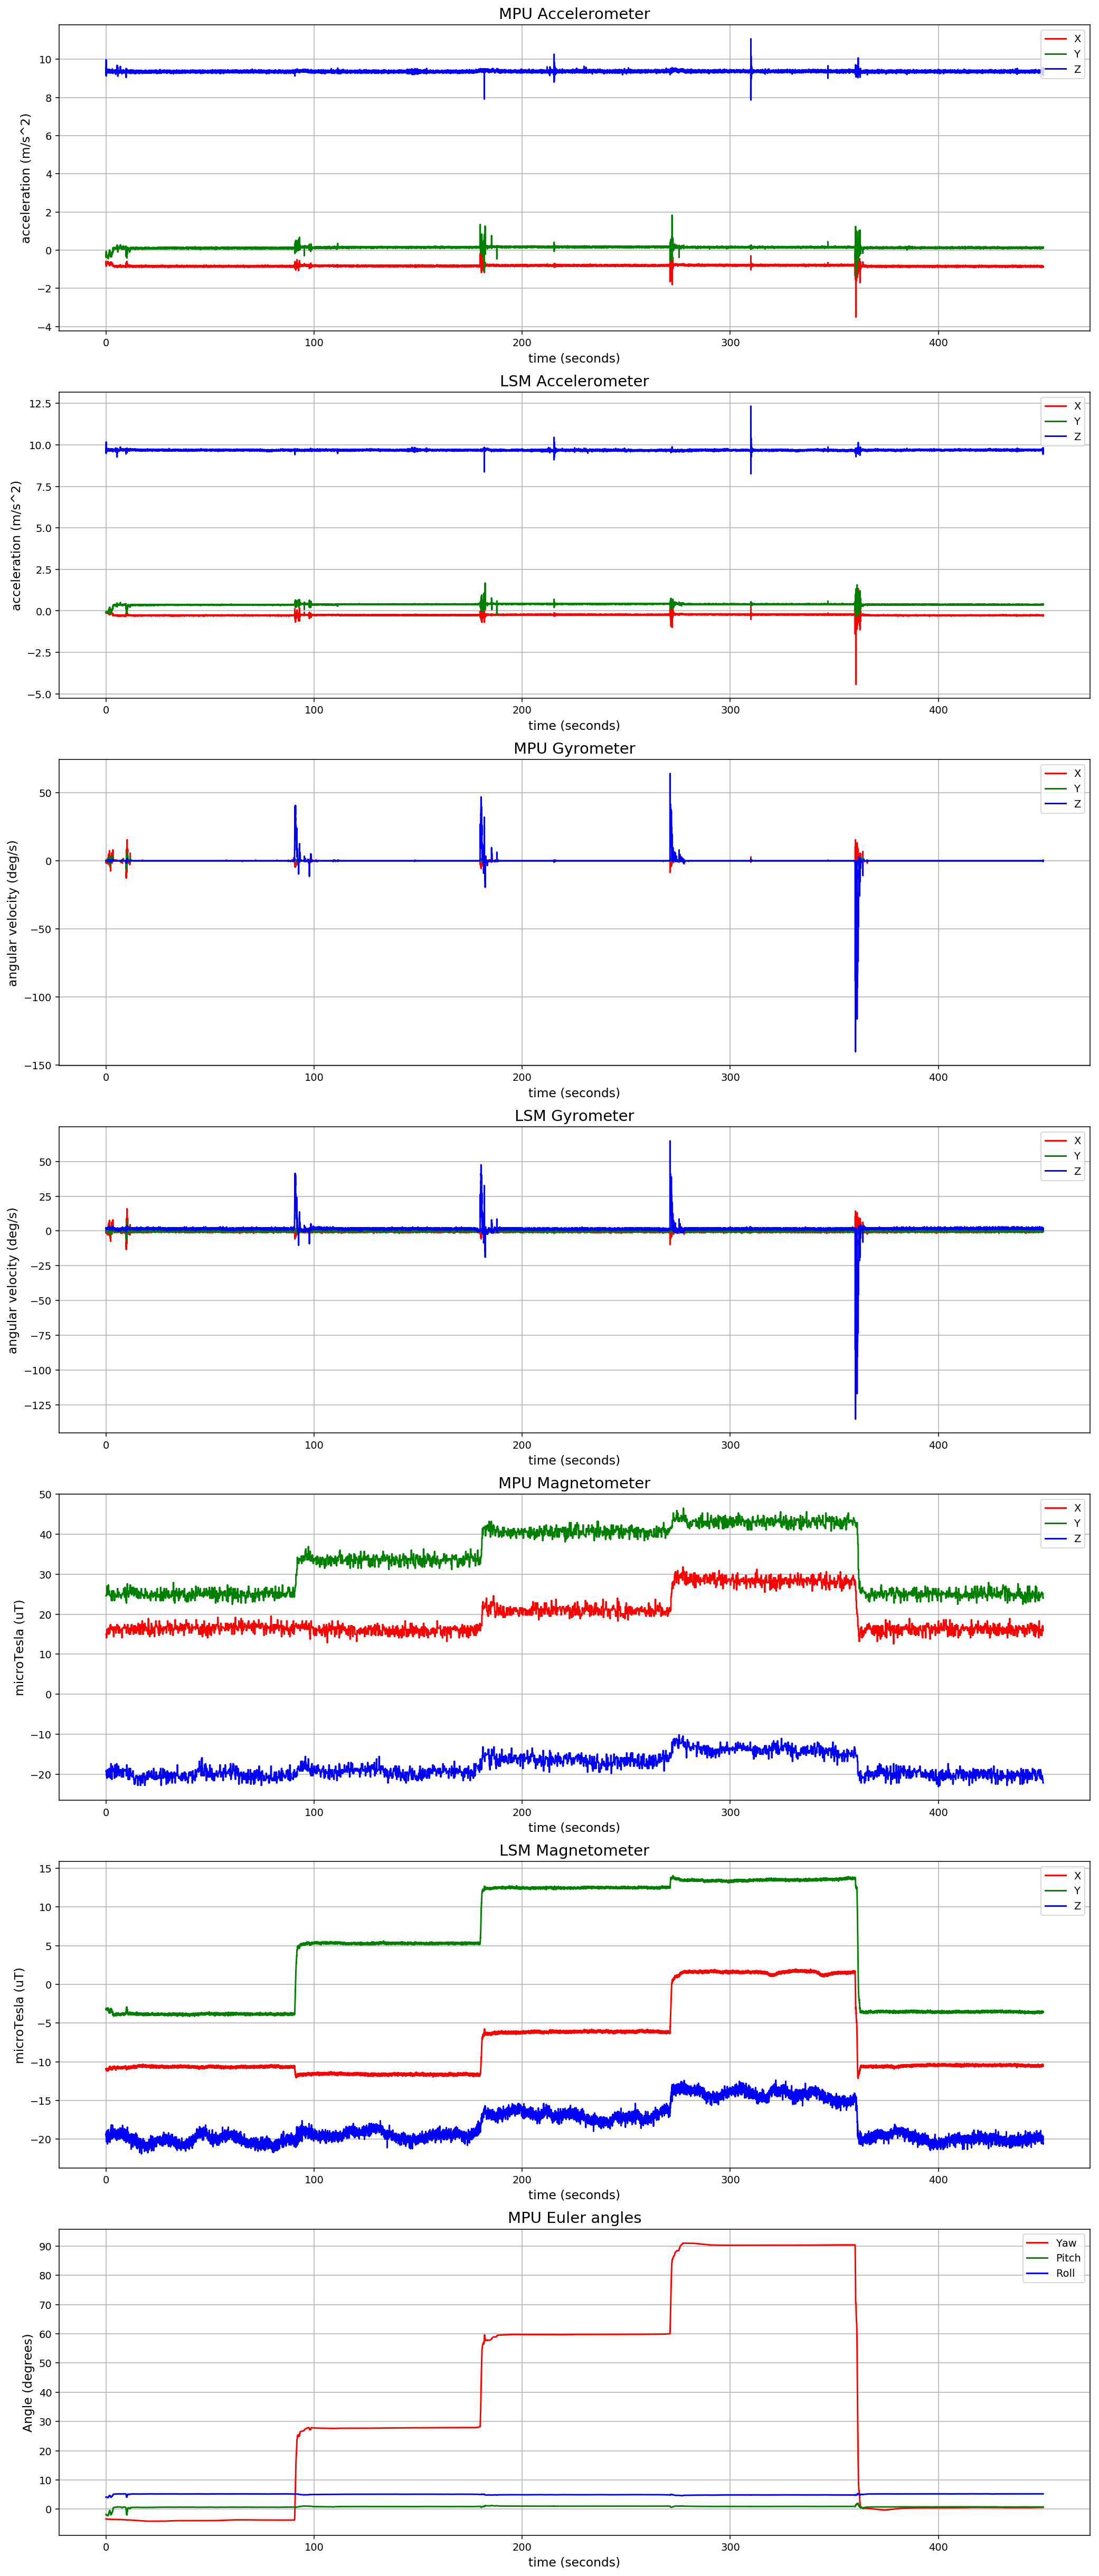

In [27]:
n = len(dataset1)
t = dataset1.runtime
x = list(np.linspace(0, t, n))

plt.close()
plt.figure(num=None, figsize=(18, 45), dpi=140)

# plt.suptitle('Raw MPU/LSM for 360-CW-Yaw (LPF=42Hz)', fontsize=22)

plt.subplot(711)
plt.plot(x,  list(MPU_acc[:,0:1].squeeze()), 'r-')
plt.plot(x,  list(MPU_acc[:,1:2].squeeze()), 'g-')
plt.plot(x,  list(MPU_acc[:,2:3].squeeze()), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("acceleration (m/s^2)", fontsize=12)
plt.grid()
plt.title("MPU Accelerometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')

plt.subplot(712)
plt.plot(x,  list(LSM_acc[:,0:1].squeeze()), 'r-')
plt.plot(x,  list(LSM_acc[:,1:2].squeeze()), 'g-')
plt.plot(x,  list(LSM_acc[:,2:3].squeeze()), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("acceleration (m/s^2)", fontsize=12)
plt.grid()
plt.title("LSM Accelerometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')

plt.subplot(713)
plt.plot(x,  list(MPU_gyr[:,0:1].squeeze()*180/np.pi), 'r-')
plt.plot(x,  list(MPU_gyr[:,1:2].squeeze()*180/np.pi), 'g-')
plt.plot(x,  list(MPU_gyr[:,2:3].squeeze()*180/np.pi), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("angular velocity (deg/s)", fontsize=12)
plt.grid()
plt.title("MPU Gyrometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')

plt.subplot(714)
plt.plot(x,  list(LSM_gyr[:,0:1].squeeze()*180/np.pi), 'r-')
plt.plot(x,  list(LSM_gyr[:,1:2].squeeze()*180/np.pi), 'g-')
plt.plot(x,  list(LSM_gyr[:,2:3].squeeze()*180/np.pi), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("angular velocity (deg/s)", fontsize=12)
plt.grid()
plt.title("LSM Gyrometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')

plt.subplot(715)
plt.plot(x,  list(MPU_mag[:,0:1].squeeze()), 'r-')
plt.plot(x,  list(MPU_mag[:,1:2].squeeze()), 'g-')
plt.plot(x,  list(MPU_mag[:,2:3].squeeze()), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("microTesla (uT)", fontsize=12)
plt.grid()
plt.title("MPU Magnetometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')

plt.subplot(716)
plt.plot(x,  list(LSM_mag[:,0:1].squeeze()), 'r-')
plt.plot(x,  list(LSM_mag[:,1:2].squeeze()), 'g-')
plt.plot(x,  list(LSM_mag[:,2:3].squeeze()), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("microTesla (uT)", fontsize=12)
plt.grid()
plt.title("LSM Magnetometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')

plt.subplot(717)
plt.plot(x,  MPU_yaw.squeeze(), 'r-')
plt.plot(x,  MPU_pitch.squeeze(), 'g-')
plt.plot(x,  MPU_roll.squeeze(), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("Angle (degrees)", fontsize=12)
plt.yticks(np.arange(0, 100, step=10))
plt.grid()
plt.title("MPU Euler angles", fontsize=15)
plt.legend(['Yaw', 'Pitch', 'Roll'], loc='upper right')

plt.savefig("angle_drift_check.png")
plt.show()

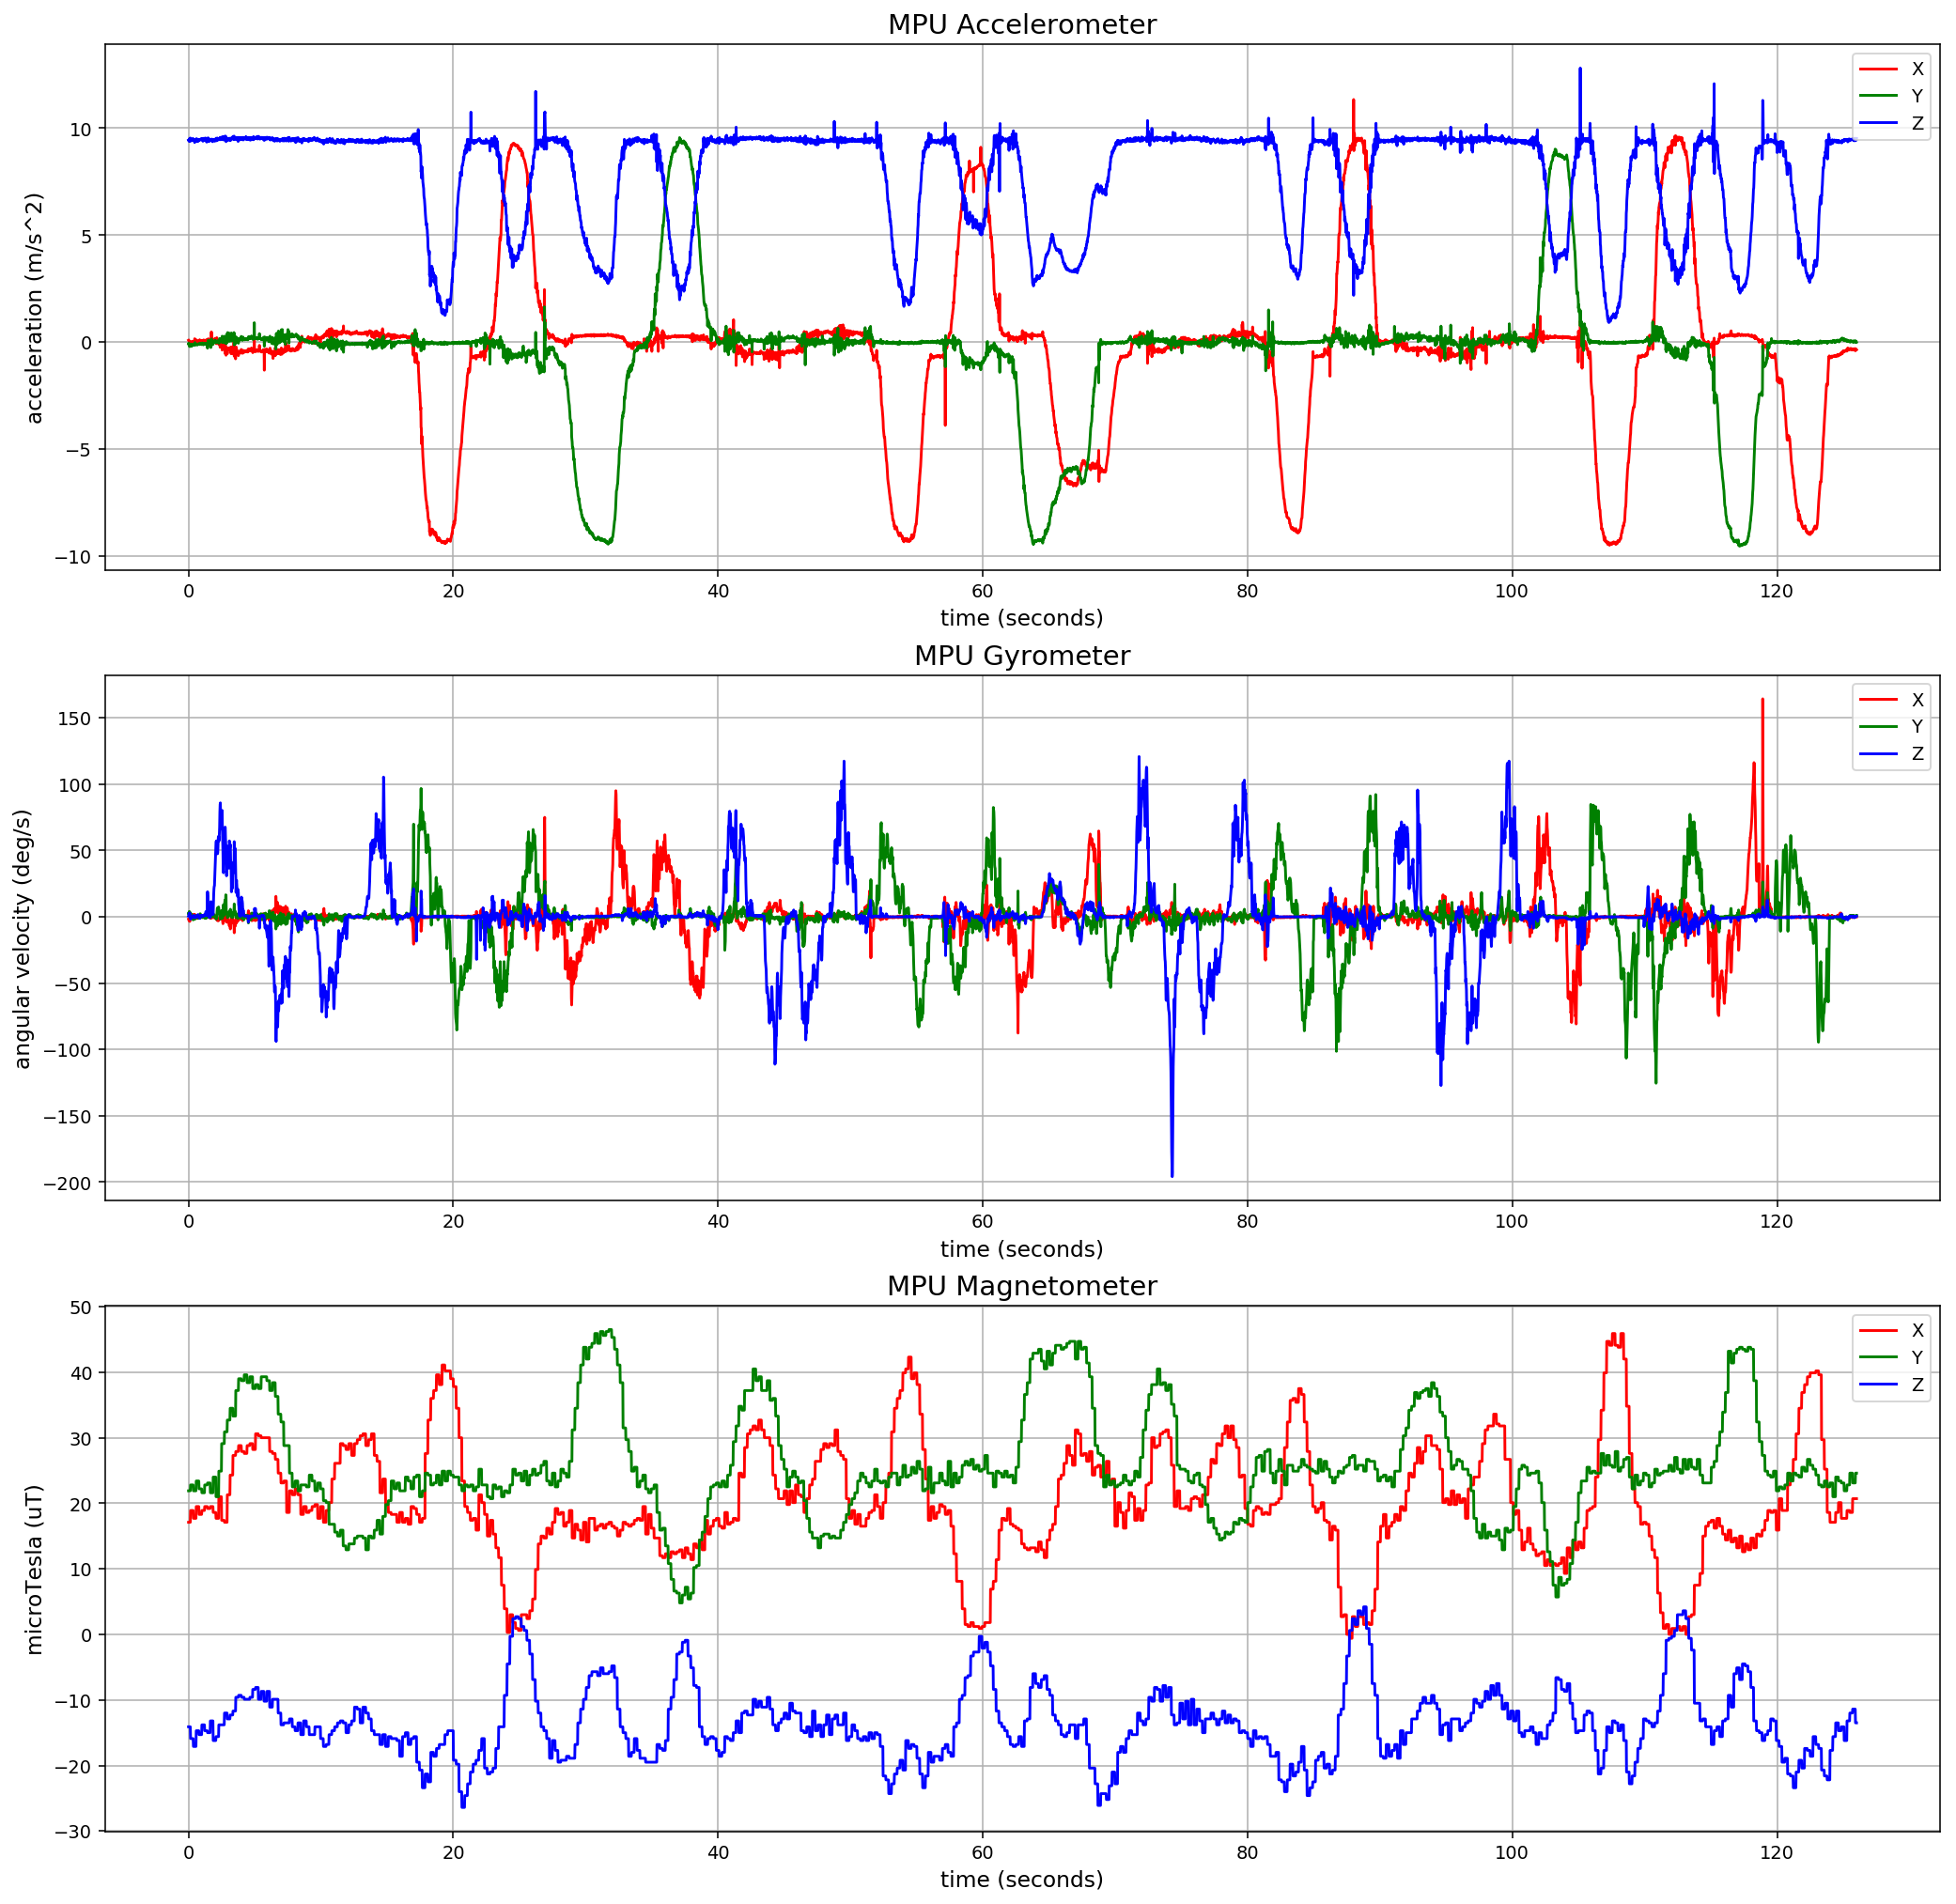

In [13]:
n = len(dataset1)
t = dataset1.runtime
x = list(np.linspace(0, t, n))

plt.close()
plt.figure(num=None, figsize=(18, 18), dpi=140)

# plt.suptitle('Raw MPU/LSM for 360-CW-Yaw (LPF=42Hz)', fontsize=22)

plt.subplot(311)
plt.plot(x,  list(MPU_acc[:,0:1].squeeze()), 'r-')
plt.plot(x,  list(MPU_acc[:,1:2].squeeze()), 'g-')
plt.plot(x,  list(MPU_acc[:,2:3].squeeze()), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("acceleration (m/s^2)", fontsize=12)
plt.grid()
plt.title("MPU Accelerometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')

plt.subplot(312)
plt.plot(x,  list(MPU_gyr[:,0:1].squeeze()*180/np.pi), 'r-')
plt.plot(x,  list(MPU_gyr[:,1:2].squeeze()*180/np.pi), 'g-')
plt.plot(x,  list(MPU_gyr[:,2:3].squeeze()*180/np.pi), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("angular velocity (deg/s)", fontsize=12)
plt.grid()
plt.title("MPU Gyrometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')

plt.subplot(313)
plt.plot(x,  list(MPU_mag[:,0:1].squeeze()), 'r-')
plt.plot(x,  list(MPU_mag[:,1:2].squeeze()), 'g-')
plt.plot(x,  list(MPU_mag[:,2:3].squeeze()), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("microTesla (uT)", fontsize=12)
plt.grid()
plt.title("MPU Magnetometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')

plt.savefig("MPU_raw_data.png")
plt.show()

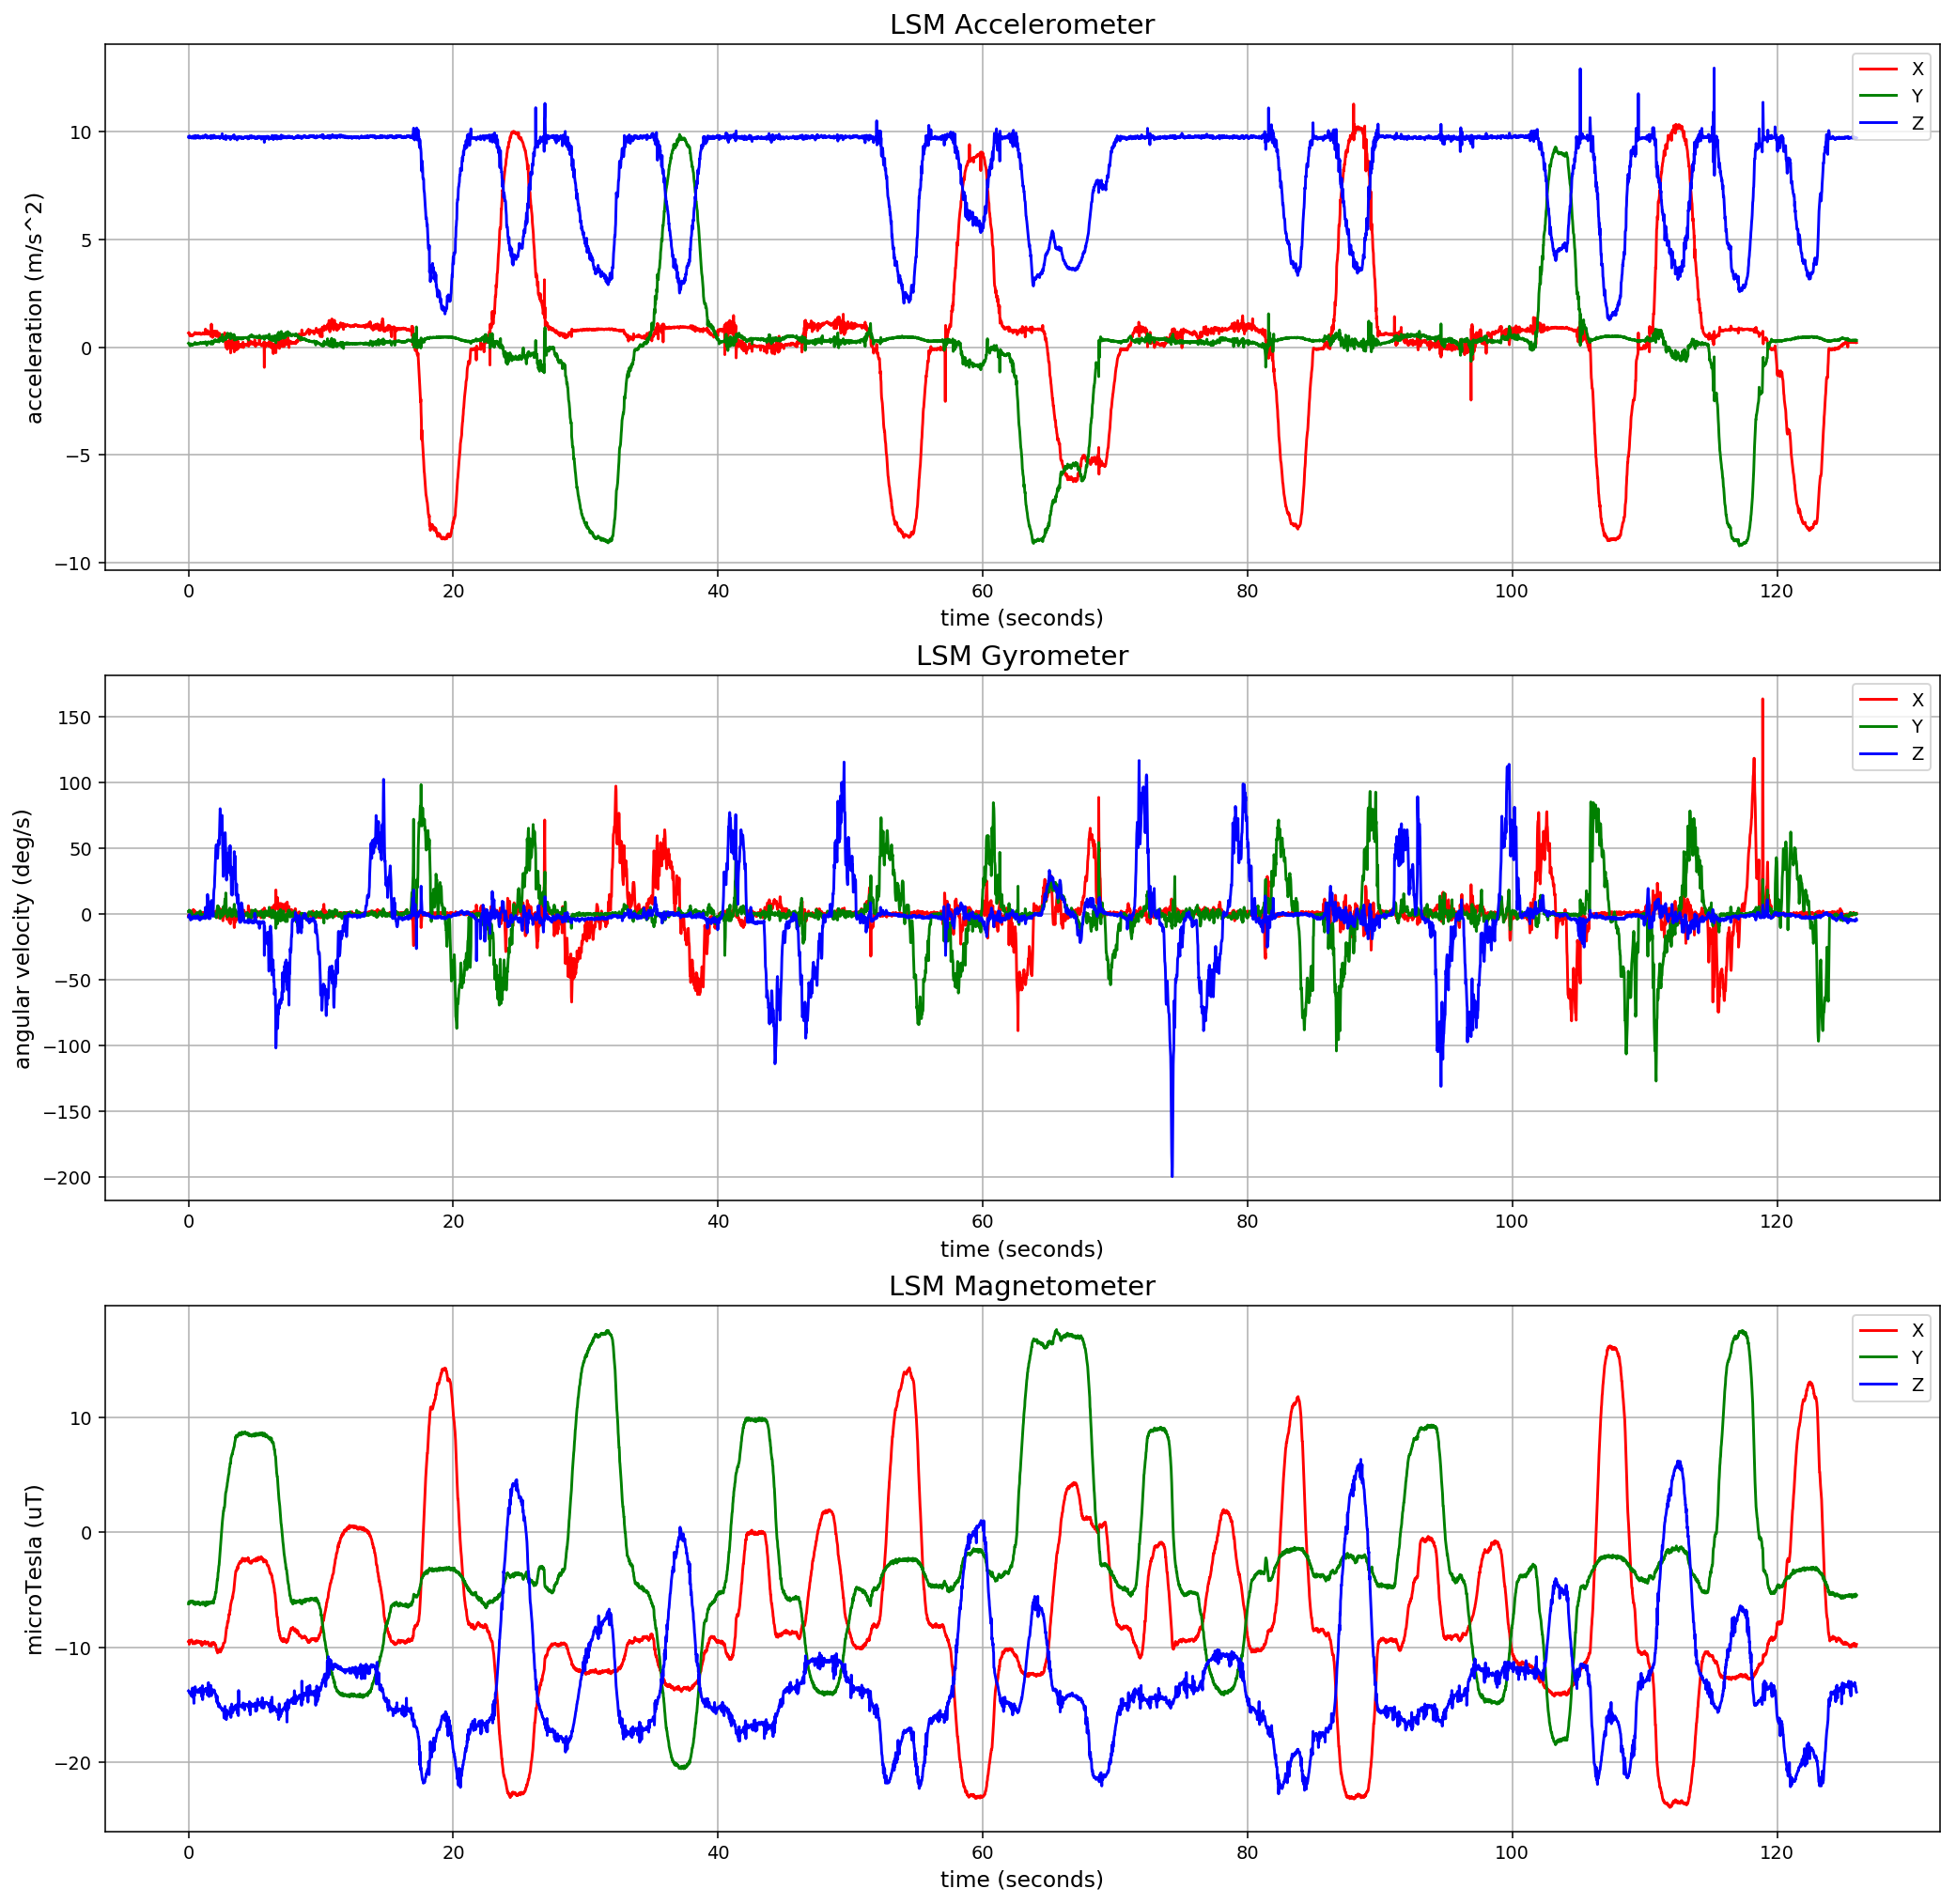

In [14]:
n = len(dataset1)
t = dataset1.runtime
x = list(np.linspace(0, t, n))

plt.close()
plt.figure(num=None, figsize=(18, 18), dpi=140)

# plt.suptitle('Raw MPU/LSM for 360-CW-Yaw (LPF=42Hz)', fontsize=22)

plt.subplot(311)
plt.plot(x,  list(LSM_acc[:,0:1].squeeze()), 'r-')
plt.plot(x,  list(LSM_acc[:,1:2].squeeze()), 'g-')
plt.plot(x,  list(LSM_acc[:,2:3].squeeze()), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("acceleration (m/s^2)", fontsize=12)
plt.grid()
plt.title("LSM Accelerometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')


plt.subplot(312)
plt.plot(x,  list(LSM_gyr[:,0:1].squeeze()*180/np.pi), 'r-')
plt.plot(x,  list(LSM_gyr[:,1:2].squeeze()*180/np.pi), 'g-')
plt.plot(x,  list(LSM_gyr[:,2:3].squeeze()*180/np.pi), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("angular velocity (deg/s)", fontsize=12)
plt.grid()
plt.title("LSM Gyrometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')


plt.subplot(313)
plt.plot(x,  list(LSM_mag[:,0:1].squeeze()), 'r-')
plt.plot(x,  list(LSM_mag[:,1:2].squeeze()), 'g-')
plt.plot(x,  list(LSM_mag[:,2:3].squeeze()), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("microTesla (uT)", fontsize=12)
plt.grid()
plt.title("LSM Magnetometer", fontsize=15)
plt.legend(['X', 'Y', 'Z'], loc='upper right')

plt.savefig("LSM_raw_data.png")
plt.show()

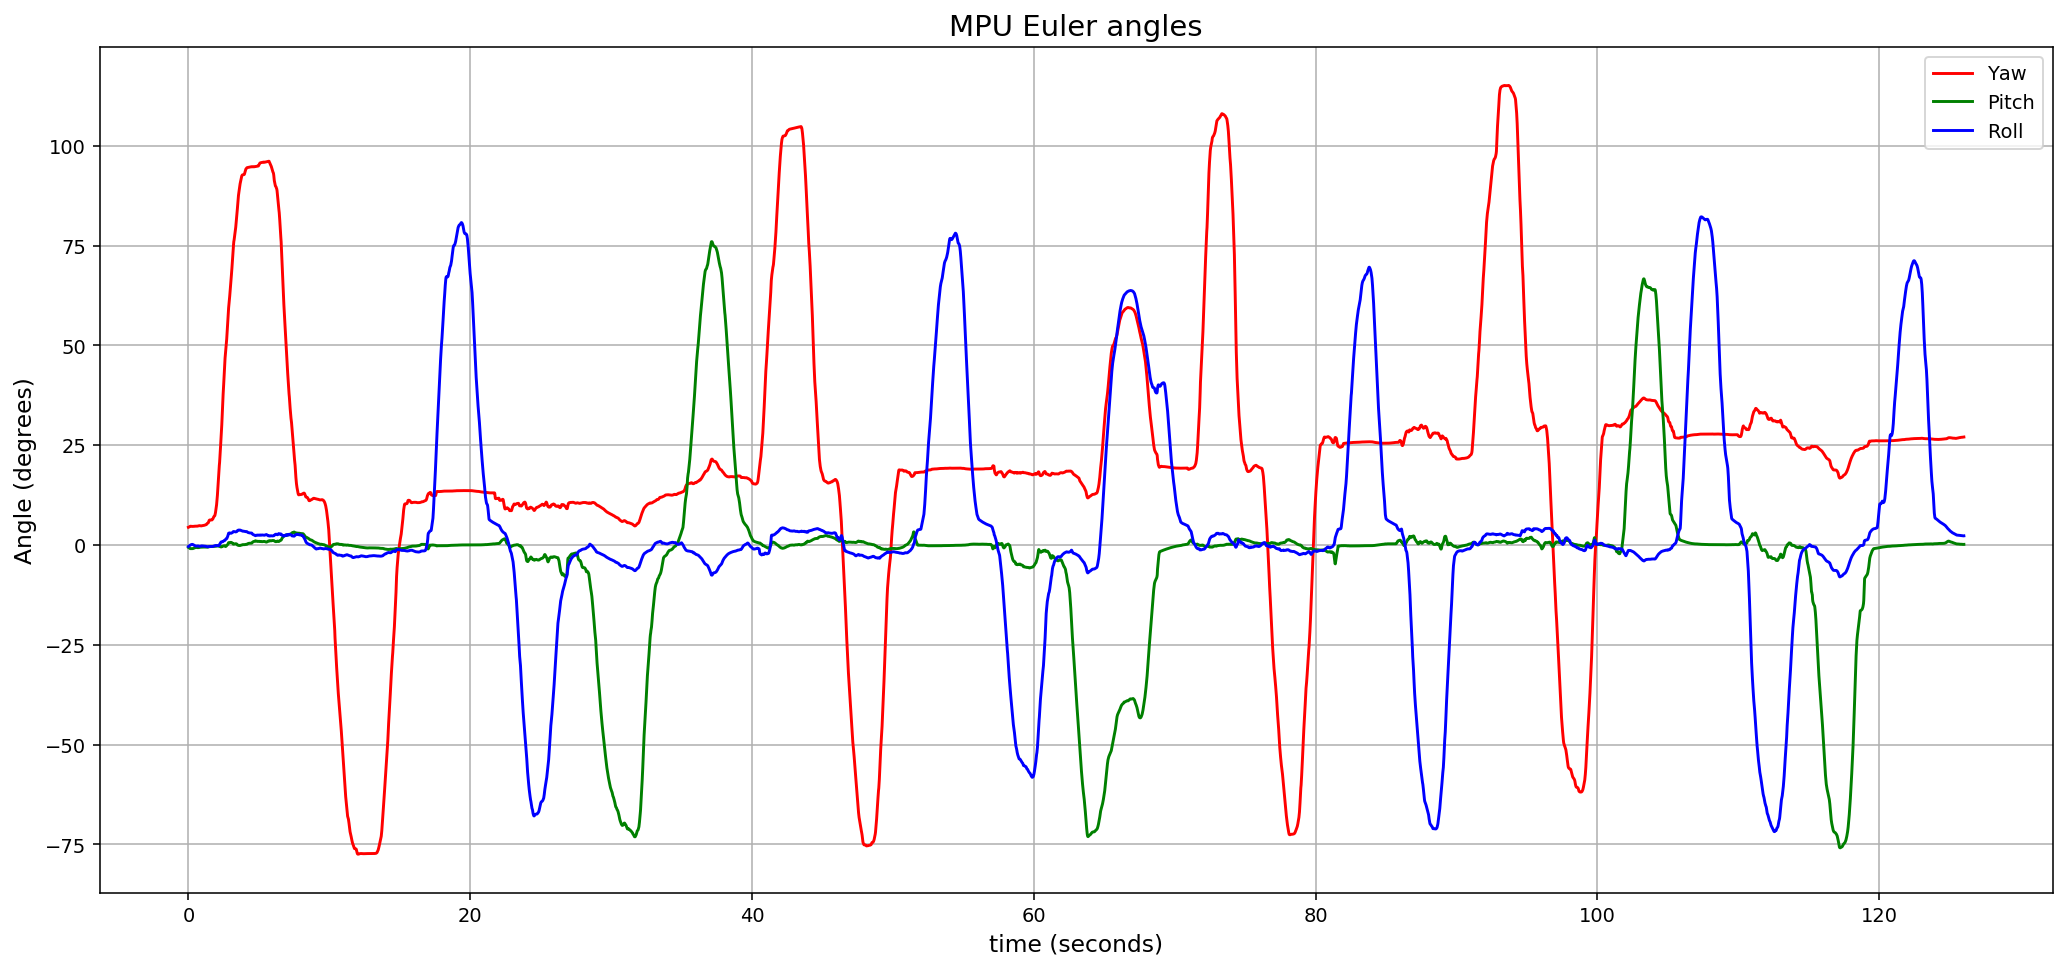

In [19]:
n = len(dataset1)
t = dataset1.runtime
x = list(np.linspace(0, t, n))

plt.close()
plt.figure(num=None, figsize=(18, 8), dpi=140)

plt.plot(x,  MPU_yaw.squeeze(), 'r-')
plt.plot(x,  MPU_pitch.squeeze(), 'g-')
plt.plot(x,  MPU_roll.squeeze(), 'b-')
plt.xlabel("time (seconds)", fontsize=12)
plt.ylabel("Angle (degrees)", fontsize=12)
plt.grid()
plt.title("MPU Euler angles", fontsize=15)
plt.legend(['Yaw', 'Pitch', 'Roll'], loc='upper right')

plt.savefig("MPU_euler_angles.png")
plt.show()